In [1]:
import matplotlib.pyplot as plt
import nltk
import re
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from itertools import chain
from nltk.corpus import inaugural
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# set seaborn settings
sns.set(font='serif', style='whitegrid')

# define colors for war and peace
color_peace ="#2ecc71"
color_war = "#e74c3c"

In [3]:
# load spacy model
nlp = spacy.load("en_core_web_sm")

In [4]:
# load speech texts
president_speeches = [inaugural.raw(fileid) for fileid in inaugural.fileids()]

In [5]:
# with this function I extract the nouns of the corpus
def extract_topics(text):
    doc = nlp(text)
    token_list = []
    for sent in doc.sents:
        for tok in sent:
            if not tok.is_stop and tok.pos_ == 'NOUN':
                # lemma and lower the noun
                token_list.append(tok.lemma_.lower())
    return token_list

In [6]:
# transform the data to tfidf
def create_tfidf(president_topics):
    # use the already tokenized list from spacy
    count = TfidfVectorizer(analyzer=lambda x:x)
    bag_of_words = count.fit_transform(president_topics)
    feature_names = count.get_feature_names()
    tfidf_df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names).T
    # change columns to just the years
    tfidf_df.columns = [fieldid[:4] for fieldid in inaugural.fileids()]
    return tfidf_df

In [7]:
# extract topics
president_topics = [extract_topics(speech) for speech in president_speeches]
# create tfidf dataframe
tfidf_df = create_tfidf(president_topics)

In [8]:
# plots the N most frequent nouns
def plot_most_frequent_nouns(president_topics, TOP_N):
    freq_dist = nltk.FreqDist(chain.from_iterable(president_topics))
    aspects, values = zip(*freq_dist.most_common()[:TOP_N])
    fig, ax = plt.subplots()
    color_list = list(np.repeat('gray',15))
    # set colors for war and peace
    color_list[9] = color_peace
    color_list[14] = color_war
    ax.barh(list(aspects), list(values),color=color_list)
    ax.set_xlabel('Frequency')
    ax.set_title('Most common nouns/topics')
    fig.tight_layout()
    fig.savefig('images/most_frequent_nouns.png')

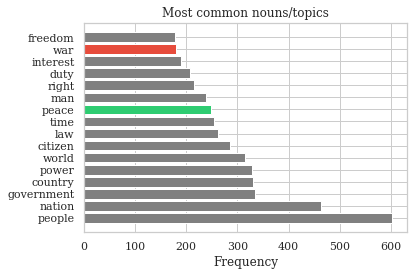

In [9]:
plot_most_frequent_nouns(president_topics, TOP_N=16)

In [10]:
# plot the tfidf of the nouns war and peace over time
def plot_war_and_peace_time(data):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(data.loc['war',:], color=color_war)
    ax.plot(data.loc['peace',:], color=color_peace)
    ax.legend()
    ax.set_ylabel('TfIdf Score')
    ax.annotate('War of 1812', xy=('1817', 0.35))
    ax.annotate('American Civil War', xy=('1869', 0.37))
    #ax.annotate('World War I', xy=('1909', 0.18))
    ax.annotate('World War II', xy=('1937', 0.22))
    ax.annotate('Vietnam War', xy=('1965', 0.35))
    ax.legend(title='Noun', shadow=True, fancybox=True)
    ax.set_title('Importance of war and peace over time')
    plt.xticks(rotation=45)
    fig.tight_layout()
    fig.savefig('images/war_and_peace_time.png')

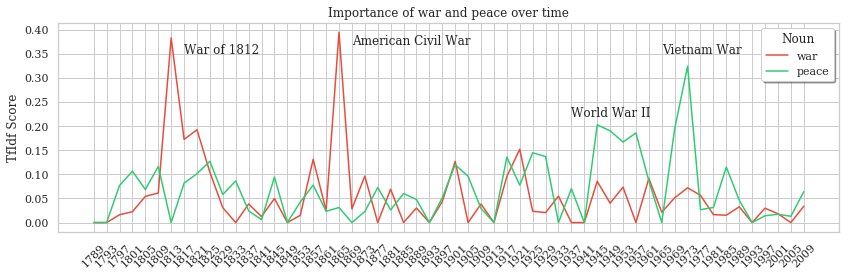

In [11]:
plot_war_and_peace_time(tfidf_df)

In [12]:
# plot the top N words (tfidf) for the four peak points
def plot_words_peek_years(data, TOP_N):
    president_list = ['Madison', 'Lincoln', 'Eisenhower','Nixon']
    year_list = [1813, 1865, 1957, 1973]
    color_list = [color_war, color_war, color_peace, color_peace]
    row_ind = [0,0,1,1]
    col_ind = [0,1,0,1]
    fig, ax = plt.subplots(ncols=2,nrows=2, sharex=True)
    fig.suptitle('Most important nouns/topics for peak speeches')
    for president, year, color, i, j in zip(president_list, year_list, 
                                            color_list, row_ind, col_ind):
        # top words with corresponding tfidf
        d = data.loc[:,str(year)].sort_values(ascending=False).reset_index()[:TOP_N]
        ax[i,j].barh(d.iloc[:,0],d.iloc[:,1],color=color)
        ax[i,j].set_title(f'{president} {year}')
    ax[1,1].set_xlabel('tfidf score')
    ax[1,0].set_xlabel('tfidf score')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig('images/peek_years.png')

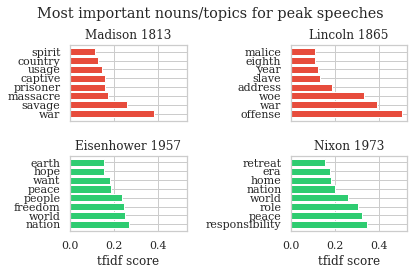

In [13]:
plot_words_peek_years(tfidf_df, TOP_N=8)